# Importation des bibliothèques nécessaires

In [1]:
import numpy as np 
import pandas as pd 
import json
import re
import random
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Embedding, LSTM, LayerNormalization, Dense, Dropout

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from flask import Flask, jsonify, render_template, request

import warnings
warnings.filterwarnings('ignore')

# importation de la base de données

### la base de données contient des questions avec des réponses sur la santé mentale.
**l'objectif** est créer un chatbot capable de soutenir les gens en répondant à leurs problèmes.

In [2]:
with open('intents.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data['intents'])

In [3]:
dic = {"tag":[], "patterns":[], "responses":[]}
for example in data['intents']:
    for pattern in example['patterns']:
        dic['patterns'].append(pattern)
        dic['tag'].append(example['tag'])
        dic['responses'].append(example['responses'])

In [4]:
df = pd.DataFrame.from_dict(dic)
df

,tag,patterns,responses
0,greeting,Hi,[Hello there. Tell me how are you feeling toda...
1,greeting,Hey,[Hello there. Tell me how are you feeling toda...
2,greeting,Is anyone there?,[Hello there. Tell me how are you feeling toda...
3,greeting,Hi there,[Hello there. Tell me how are you feeling toda...
4,greeting,Hello,[Hello there. Tell me how are you feeling toda...
...,...,...,...
227,fact-29,How do I know if I'm unwell?,"[If your beliefs , thoughts , feelings or beha..."
228,fact-30,How can I maintain social connections? What if...,"[A lot of people are alone right now, but we d..."
229,fact-31,What's the difference between anxiety and stress?,[Stress and anxiety are often used interchange...
230,fact-32,What's the difference between sadness and depr...,"[Sadness is a normal reaction to a loss, disap..."


## Distribution des intentions

In [5]:
df['tag'].unique()

array(['greeting', 'morning', 'afternoon', 'evening', 'night', 'goodbye',
       'thanks', 'no-response', 'neutral-response', 'about', 'skill',
       'creation', 'name', 'help', 'sad', 'stressed', 'worthless',
       'depressed', 'happy', 'casual', 'anxious', 'not-talking', 'sleep',
       'scared', 'death', 'understand', 'done', 'suicide', 'hate-you',
       'hate-me', 'default', 'jokes', 'repeat', 'wrong', 'stupid',
       'location', 'something-else', 'friends', 'ask', 'problem',
       'no-approach', 'learn-more', 'user-agree', 'meditation',
       'user-meditation', 'pandora-useful', 'user-advice',
       'learn-mental-health', 'mental-health-fact', 'fact-1', 'fact-2',
       'fact-3', 'fact-5', 'fact-6', 'fact-7', 'fact-8', 'fact-9',
       'fact-10', 'fact-11', 'fact-12', 'fact-13', 'fact-14', 'fact-15',
       'fact-16', 'fact-17', 'fact-18', 'fact-19', 'fact-20', 'fact-21',
       'fact-22', 'fact-23', 'fact-24', 'fact-25', 'fact-26', 'fact-27',
       'fact-28', 'fact-29', '

In [6]:
df['tag'].nunique()

80

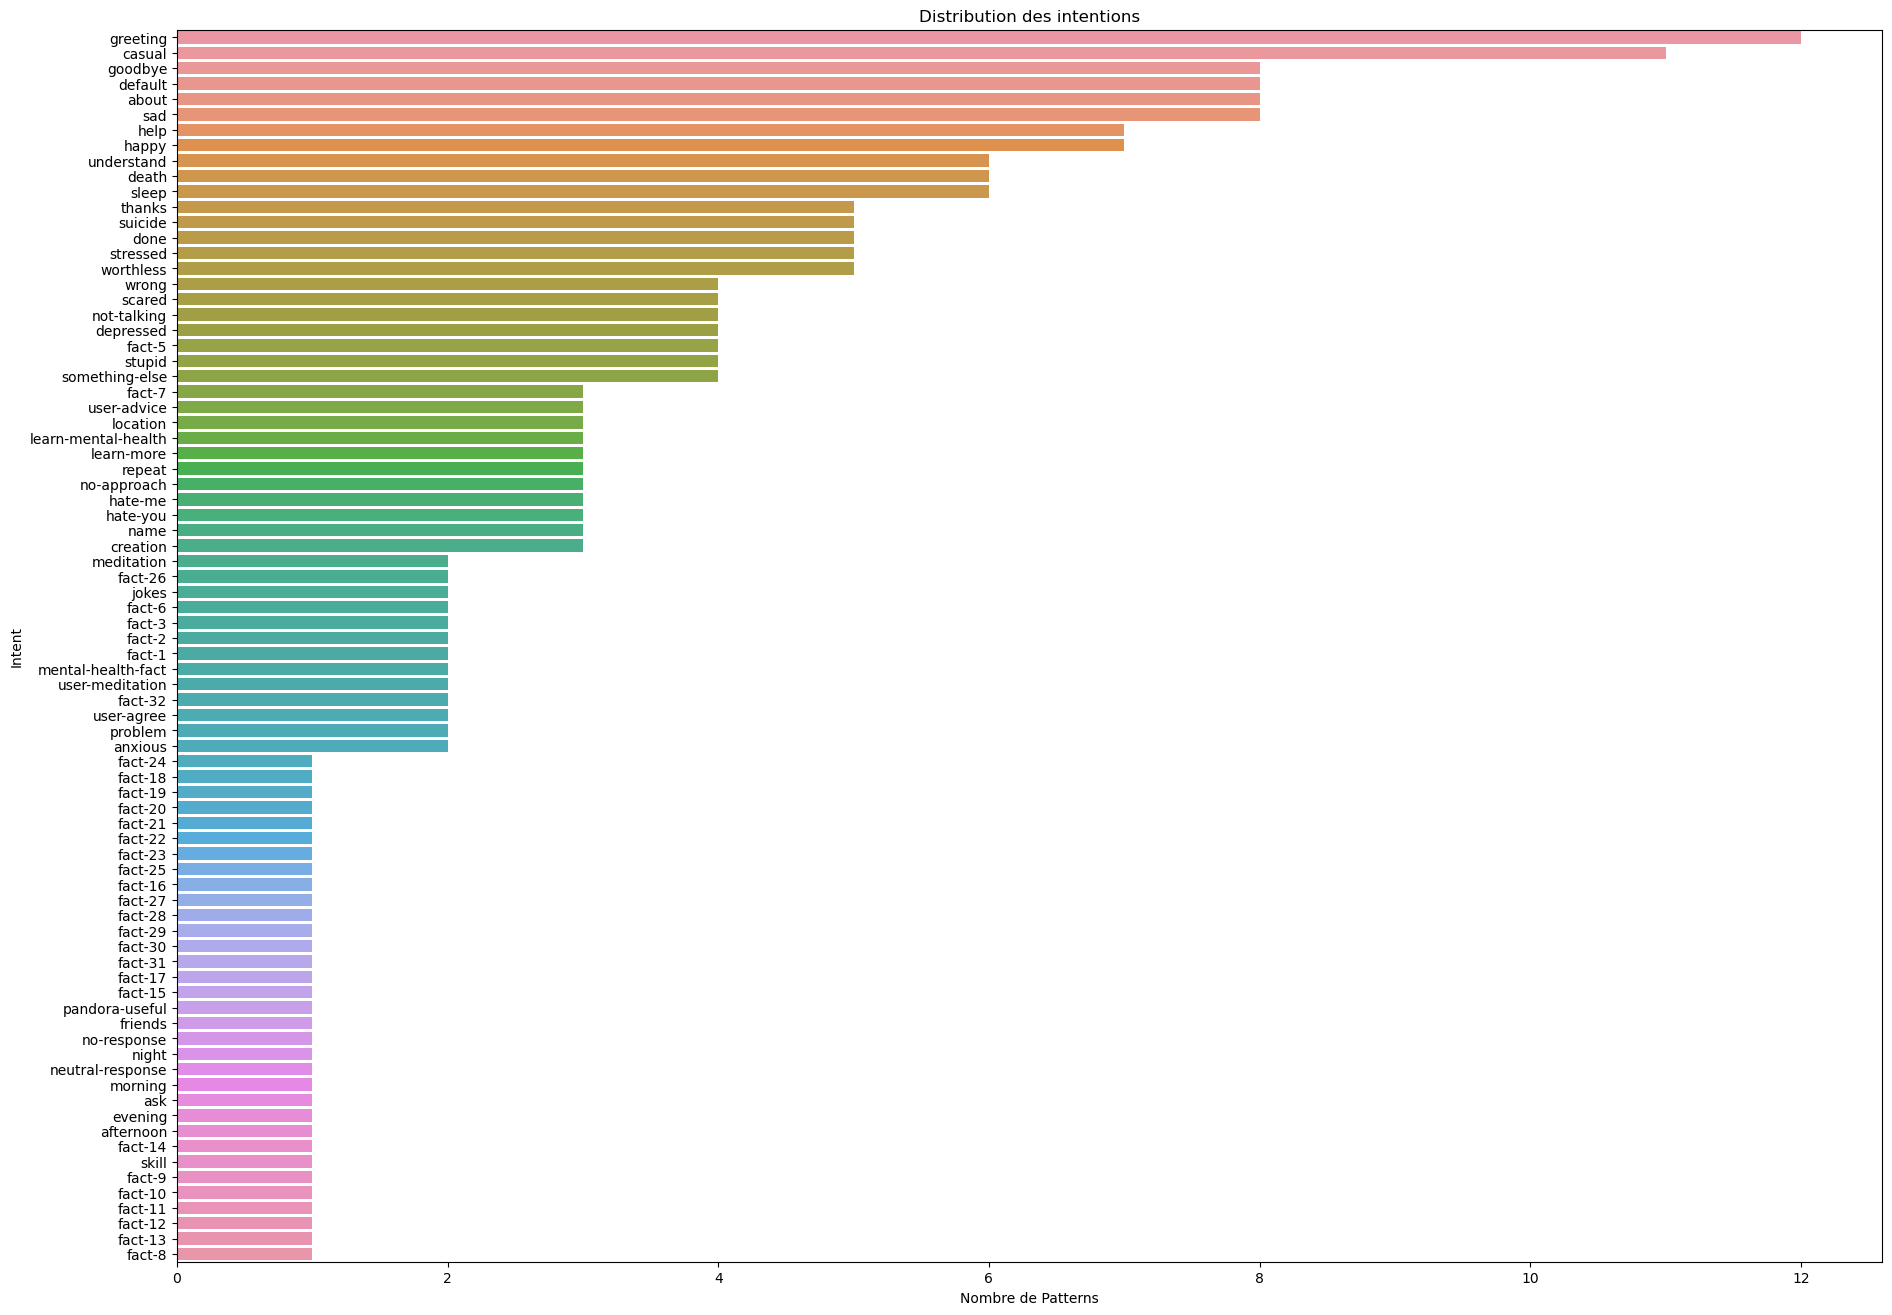

In [7]:
plt.figure(figsize=(22, 16))
sns.countplot(y='tag', data=df, order=df['tag'].value_counts().index)
plt.title('Distribution des intentions')
plt.xlabel('Nombre de Patterns')
plt.ylabel('Intent')
plt.show()

## Pré-tratement

#### Appliquer quelques techniques de prétraitement de texte telles que la mise en minuscules, la suppression de la ponctuation, puis la tokenisation des motifs (patterns).


In [8]:
tokenizer = Tokenizer(lower=True, split=' ')
tokenizer.fit_on_texts(df['patterns'])
print(tokenizer.get_config()['filters'])

!"#$%&()*+,-./:;<=>?@[\]^_`{|}~	



In [9]:
vacab_size = len(tokenizer.word_index)
print('Nombre de mots uniques = ', vacab_size)

Nombre de mots uniques =  303


In [10]:
ptrn2seq = tokenizer.texts_to_sequences(df['patterns'])
ptrn2seq[1:10]

[[96], [14, 97, 41], [95, 41], [150], [96, 41], [151], [152], [153], [154]]

In [11]:
X = pad_sequences(ptrn2seq, padding='post')
print('X shape = ', X.shape)

X shape =  (232, 18)


In [12]:
lbl_enc = LabelEncoder() # pour créer des étiquettes
y = lbl_enc.fit_transform(df['tag'])
print('y shape = ', y.shape)
print('num of classes = ', len(np.unique(y)))
y

y shape =  (232,)
num of classes =  80


array([44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 44, 55,  1, 10, 58, 43,
       43, 43, 43, 43, 43, 43, 43, 73, 73, 73, 73, 73, 60, 57,  0,  0,  0,
        0,  0,  0,  0,  0, 67,  5,  5,  5, 56, 56, 56, 48, 48, 48, 48, 48,
       48, 48, 65, 65, 65, 65, 65, 65, 65, 65, 70, 70, 70, 70, 70, 78, 78,
       78, 78, 78,  8,  8,  8,  8, 45, 45, 45, 45, 45, 45, 45,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  4,  4,  2,  2, 61, 61, 61, 61, 68, 68, 68,
       68, 68, 68, 66, 66, 66, 66,  6,  6,  6,  6,  6,  6, 74, 74, 74, 74,
       74, 74,  9,  9,  9,  9,  9, 72, 72, 72, 72, 72, 47, 47, 47, 46, 46,
       46,  7,  7,  7,  7,  7,  7,  7,  7, 49, 49, 64, 64, 64, 79, 79, 79,
       79, 71, 71, 71, 71, 52, 52, 52, 69, 69, 69, 69, 42,  3, 63, 63, 59,
       59, 59, 51, 51, 51, 76, 76, 53, 53, 77, 77, 62, 75, 75, 75, 50, 50,
       50, 54, 54, 11, 11, 22, 22, 33, 33, 37, 37, 37, 37, 38, 38, 39, 39,
       39, 40, 41, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 24, 25, 26,
       27, 28, 29, 29, 30

## Division de notre base de données

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
print("Forme de X_train :", X_train.shape)
print("Forme de X_test :", X_test.shape)
print("Forme de y_train :", y_train.shape)
print("Forme de y_test :", y_test.shape)

Forme de X_train : (185, 18)
Forme de X_test : (47, 18)
Forme de y_train : (185,)
Forme de y_test : (47,)


# Architecure du modèle

In [15]:
model = Sequential()
model.add(Input(shape=(X.shape[1],)))
model.add(Embedding(input_dim=vacab_size+1, output_dim=100))
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32, return_sequences=True))
model.add(LayerNormalization())
model.add(LSTM(32))
model.add(LayerNormalization())
model.add(Dense(128, activation="relu"))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(np.unique(y)), activation="softmax"))
model.compile(optimizer='adam', loss="sparse_categorical_crossentropy", metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 18, 100)             │          30,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 18, 32)              │          17,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 18, 32)              │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 18, 32)              │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 18, 32)              │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 32)                  │              64 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           4,224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 128)                 │             256 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 80)                  │          10,320 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 79,056 (308.81 KB)

 Trainable params: 79,056 (308.81 KB)

 Non-trainable params: 0 (0.00 B)

# Entrainement du modèle  

In [16]:
model_history = model.fit(x=X,
                          y=y,
                          batch_size=10,
                          callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=3)],
                          # Arrête l'entraînement si l'accuracy ne s'améliore plus après 3 époques.
                          epochs=100)

Epoch 1/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.0118 - loss: 4.9576  
Epoch 2/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0428 - loss: 4.4166
Epoch 3/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0861 - loss: 3.8894
Epoch 4/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.1340 - loss: 3.7853
Epoch 5/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2047 - loss: 3.3827
Epoch 6/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2128 - loss: 3.1002
Epoch 7/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3562 - loss: 2.6640
Epoch 8/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3498 - loss: 2.6187
Epoch 9/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3976 - loss: 2.2937
Epoch 10/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5364 - loss: 1.9188
Epoch 11/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.5949 - loss: 1.7033
Epoch 12/100
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/st

# Evaluation du modèle

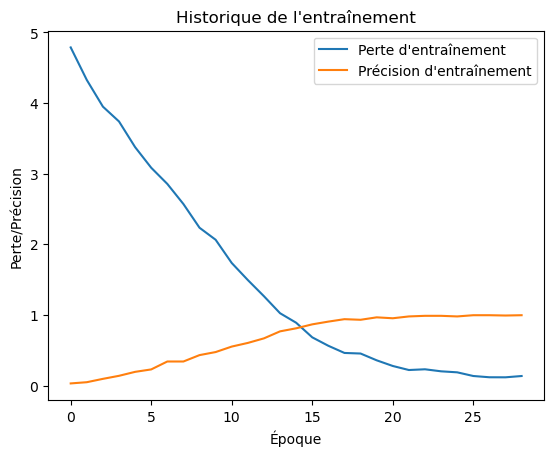

In [22]:
plt.plot(model_history.history['loss'], label='Perte d\'entraînement')
plt.plot(model_history.history['accuracy'], label='Précision d\'entraînement')
plt.xlabel('Époque')
plt.ylabel('Perte/Précision')
plt.title('Historique de l\'entraînement')
plt.legend()
plt.show()

In [24]:
test_loss, précision = model.evaluate(X_test, y_test)
print("Perte de test :", test_loss)
print("Précision de test :", précision)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.0567 
Perte de test : 0.051874395459890366
Précision de test : 1.0


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 340ms/step


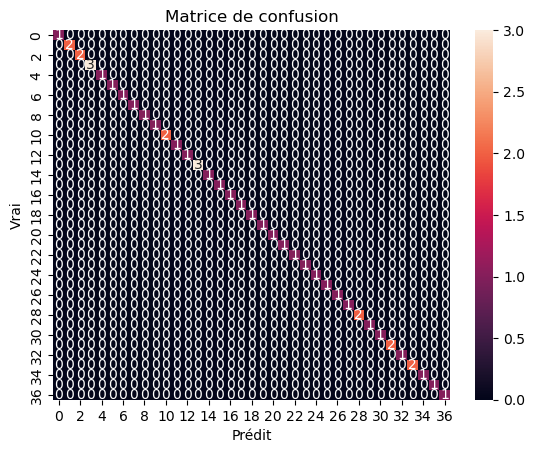

In [27]:
y_prob = model.predict(X_test)
y_pred = np.argmax(y_prob, axis=1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Prédit')
plt.ylabel('Vrai')
plt.title('Matrice de confusion')
plt.show()

# sauvegarde du modèle

In [32]:
model.save('chatbot_model.keras')

#  Test du modèle


In [15]:
model = load_model('chatbot_model.keras')

In [16]:
def generate(pattern): 
    text = []
    txt = re.sub('[^a-zA-Z\']', ' ', pattern)
    txt = txt.lower()
    txt = txt.split()
    txt = " ".join(txt)
    text.append(txt)
    x_test = tokenizer.texts_to_sequences(text)
    x_test = pad_sequences(x_test, padding='post', maxlen=X.shape[1])
    y_pred = model.predict(x_test)
    y_pred = y_pred.argmax()
    tag = lbl_enc.inverse_transform([y_pred])[0]
    responses = df[df['tag'] == tag]['responses'].values[0]
    return random.choice(responses)

### Application Web

In [ ]:
app = Flask(__name__)

@app.route('/')
def index():
    return render_template('index.html')

@app.route("/get")
def response():
    query = request.args.get('msg')
    res = generate(query)
    return jsonify({"response": res})

if __name__ == "__main__":
    app.run(host="0.0.0.0", port=5000)

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:5000
 * Running on http://192.168.14.254:5000
Press CTRL+C to quit
192.168.14.254 - - [22/May/2024 23:28:46] "GET / HTTP/1.1" 200 -
192.168.14.254 - - [22/May/2024 23:28:48] "GET /favicon.ico HTTP/1.1" 404 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 660ms/step


192.168.14.254 - - [22/May/2024 23:28:56] "GET /get?msg=hello HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


192.168.14.254 - - [22/May/2024 23:29:05] "GET /get?msg=who%20are%20you HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


192.168.14.254 - - [22/May/2024 23:29:25] "GET /get?msg=can%20you%20help%20me HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


192.168.14.254 - - [22/May/2024 23:29:39] "GET /get?msg=i%20want%20to%20change%20my%20feeling HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


192.168.14.254 - - [22/May/2024 23:29:50] "GET /get?msg=i'm%20sad HTTP/1.1" 200 -


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


192.168.14.254 - - [22/May/2024 23:30:09] "GET /get?msg=how%20old%20are%20you%20%3F HTTP/1.1" 200 -
